In [1]:
import crossref_commons.retrieval
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from src.crossref import current_timestamp
from src.github_api import ReplicationCode
from time import sleep

# GitHub API

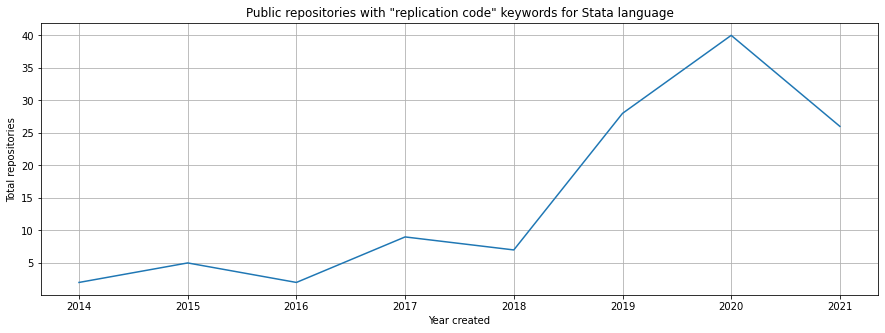

In [2]:
rc = ReplicationCode()
ghapi = rc.dataframe()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('created_at', 'count', data=ghapi)
plt.grid(b=True)
plt.title('Public repositories with "replication code" keywords for Stata language')
plt.xlabel('Year created')
plt.ylabel('Total repositories')
plt.savefig('img/replication-code-stata.png', bbox_inches = 'tight')

# AEA Deposits on ICPSR 

In [3]:
# check whether all data have been downloaded
!python3 src/aea.py --help
!python3 src/aea.py -j aer
!python3 src/aea.py -j aeri
!python3 src/aea.py -j app
!python3 src/aea.py -j pol
!python3 src/aea.py -j mac
!python3 src/aea.py -j mic
!python3 src/aea.py -j jel
!python3 src/aea.py -j jep
!python3 src/aea.py -j pandp

usage: aea.py [-h] [-j]

optional arguments:
  -h, --help       show this help message and exit
  -j , --journal   Journal name: ['aer', 'aeri', 'app', 'pol', 'mac', 'mic',
                   'jel', 'jep', 'pandp']
2021-08-26 00:52:28: https://www.aeaweb.org/journals/aer/issues
2021-08-26 00:52:29: https://www.aeaweb.org/journals/aeri/issues
2021-08-26 00:52:30: https://www.aeaweb.org/journals/app/issues
2021-08-26 00:52:32: https://www.aeaweb.org/journals/pol/issues
2021-08-26 00:52:33: https://www.aeaweb.org/journals/mac/issues
2021-08-26 00:52:35: https://www.aeaweb.org/journals/mic/issues
2021-08-26 00:52:40: HTTPSConnectionPool(host='www.aeaweb.org', port=443): Read timed out. (read timeout=5)
2021-08-26 00:52:44: https://www.aeaweb.org/journals/jel/issues
2021-08-26 00:52:45: https://www.aeaweb.org/journals/jep/issues
2021-08-26 00:52:47: https://www.aeaweb.org/journals/pandp/issues


In [4]:
aea = os.listdir('data/aea/raw')

In [5]:
def dataframe(file):
    with open(f'data/aea/raw/{file}', 'r') as f:
        data = json.load(f)

    df = pd.DataFrame(data['article'])
    df.insert(0, 'issue_url', data['issue_url'])
    df.insert(1, 'publication_date', data['publication_date'])

    return df

In [6]:
df = pd.concat([dataframe(x) for x in aea], sort=False)
df = df.reset_index(drop=True)
df['year'] = df.publication_date.apply(lambda x: x[-4:])
df['year'] = df.year.astype(str)

In [7]:
size = df.groupby('year')['icpsr'].size()
count = df.groupby('year')['icpsr'].count()
icpsr = pd.merge(size, count, on='year')
icpsr['proportion'] = icpsr.icpsr_y / icpsr.icpsr_x
icpsr = icpsr.reset_index()

In [8]:
def monthly():
    # will be used for monthly
    dates = []
    base_date = icpsr.publication_date.min()
    while base_date <= icpsr.publication_date.max():
        if base_date.day == 1:
            dates.append(base_date)
        base_date += timedelta(days=1)
    datesdf = pd.DataFrame(sorted(dates), columns=['publication_date'])

    icpsr = pd.merge(datesdf, icpsr, how='left', on='publication_date')
    icpsr.percent = icpsr.percent.fillna(0)
    
    return icpsr

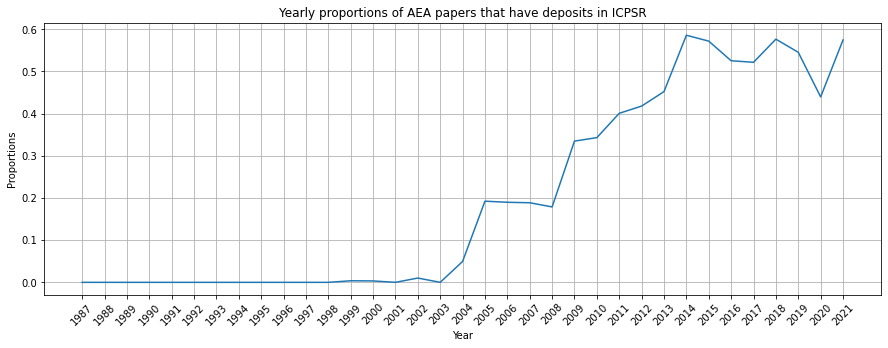

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('year', 'proportion', data=icpsr)
plt.grid(b=True)
plt.title('Yearly proportions of AEA papers that have deposits in ICPSR')
plt.xticks(rotation = 45)
plt.xlabel('Year')
plt.ylabel('Proportions')
plt.savefig('img/aea-deposit-icpsr.png', bbox_inches = 'tight')

# Top 10 econ journals

In [10]:
def check_column(data, column):
    try:
        return data[column]
    except KeyError:
        return None
    
def dataframe(path, journal, file_name):
    df = []
    for j in journal:
        with open(f'{path}/{j}', 'r') as f:
            data = json.load(f)
            url = data['URL']
            print(f'{current_timestamp()}: {url}')
            d = {
                'doi': url,
                'title': check_column(data, 'title'),
                'author': check_column(data, 'author'),
                'publisher': check_column(data, 'publisher'),
                'created': check_column(data, 'created'),
                'has_replication': has_replication(url)

            }
            df.append(d)

    pd.DataFrame(df).to_csv(f'data/has-replication/{file_name}.csv', index=False)

## American Economic Association

AEA has three journals that are listed in top 10 econ journals according to IDEAS/RePEc. They are:
- American Economic Review (#1)
- Journal of Economic Literature (#2)
- Journal of Economic Perspectives (#10)

In [11]:
path = 'data/aea/raw'
os.system(f'rm -rf {path}/.ipynb_checkpoints')
aea = os.listdir(path)
aea = [json.load(open(f'{path}/{x}', 'r')) for x in aea]

In [12]:
for i in aea:
    for j in i['article']:
        j.update({'publication_date': i['publication_date']})

In [13]:
def has_replication(journal, file_name):
    df = pd.concat([pd.DataFrame(x['article']) for x in aea], sort=False)
    df = df.reset_index(drop=True)
    df['has_replication'] = df.icpsr.apply(lambda x: x != None)
    df[journal] = df.url.apply(lambda x: f'{journal}.' in x.lower())
    df = df[df[journal] == True]
    df = df[['url', 'icpsr', 'publication_date', 'has_replication']]
    df = df.reset_index(drop=True)
    df.to_csv(f'data/has-replication/{file_name}.csv', index=False)
    
has_replication('aer', 'american-economic-review')
has_replication('jel', 'journal-of-economic-literature')
has_replication('jep', 'journal-of-economic-perspectives')

## 3. The Quarterly Journal of Economics

In [14]:
path = 'data/crossref/s-oup-qjecon'
qje = os.listdir(path)

def has_replication(url):
    '''
    DOI example that has supplementary data: https://doi.org/10.1093/qje/qjaa038
    DOI example that doesn't have any supplementary data: http://dx.doi.org/10.1093/qje/qjr049
    '''

    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            return content.find('h2', {'id': 'supplementary-data'}) != None
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, qje, 'the-quarterly-journal-of-economics')

2021-08-26 00:52:51: http://dx.doi.org/10.1162/0033553053327470
2021-08-26 00:52:55: http://dx.doi.org/10.1162/qjec.2009.124.3.1363
2021-08-26 00:52:58: http://dx.doi.org/10.1093/qje/qjr037
2021-08-26 00:53:00: http://dx.doi.org/10.1162/qjec.122.3.1103
2021-08-26 00:53:03: http://dx.doi.org/10.1162/00335530152466269
2021-08-26 00:53:06: http://dx.doi.org/10.1162/qjec.2009.124.3.1307
2021-08-26 00:53:08: http://dx.doi.org/10.1162/003355301753265598
2021-08-26 00:53:10: http://dx.doi.org/10.1093/qje/qjaa047
2021-08-26 00:53:12: http://dx.doi.org/10.1093/qje/qjs047
2021-08-26 00:53:15: http://dx.doi.org/10.1093/qje/qjs017
2021-08-26 00:53:17: http://dx.doi.org/10.1093/qje/qjr057
2021-08-26 00:53:23: http://dx.doi.org/10.1162/qjec.2009.124.2.843
2021-08-26 00:53:25: http://dx.doi.org/10.1162/003355301753265570
2021-08-26 00:53:27: http://dx.doi.org/10.1162/qjec.2009.124.4.1449
2021-08-26 00:53:29: http://dx.doi.org/10.1093/qje/qjw007
2021-08-26 00:53:32: http://dx.doi.org/10.1093/qje/qjw03

## 5. Journal of Political Economy

In [15]:
path = 'data/crossref/s-ucp-jpolec'
jpolec = os.listdir(path)

def has_replication(url):
    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            sleep(1)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            div = content.find('div', {'class': 'article__navbar__row tos-list__wrapper'})
            try:
                return 'supplemental material' in [x.text.lower() for x in div.find_all('li')]
            except:
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, jpolec, 'journal-of-political-economy')

2021-08-26 00:56:39: http://dx.doi.org/10.1086/710976
2021-08-26 00:56:41: http://dx.doi.org/10.1086/712507
2021-08-26 00:56:44: http://dx.doi.org/10.1086/686732
2021-08-26 00:56:47: http://dx.doi.org/10.1086/665405
2021-08-26 00:56:49: http://dx.doi.org/10.1086/711348
2021-08-26 00:56:51: http://dx.doi.org/10.1086/688876
2021-08-26 00:56:54: http://dx.doi.org/10.1086/498049
2021-08-26 00:56:57: http://dx.doi.org/10.1086/694293
2021-08-26 00:56:59: http://dx.doi.org/10.1086/422562
2021-08-26 00:57:02: http://dx.doi.org/10.1086/700765
2021-08-26 00:57:04: http://dx.doi.org/10.1086/658497
2021-08-26 00:57:06: http://dx.doi.org/10.1086/708817
2021-08-26 00:57:08: http://dx.doi.org/10.1086/649760
2021-08-26 00:57:12: http://dx.doi.org/10.1086/503205
2021-08-26 00:57:14: http://dx.doi.org/10.1086/705554
2021-08-26 00:57:17: http://dx.doi.org/10.1086/681592
2021-08-26 00:57:19: http://dx.doi.org/10.1086/701789
2021-08-26 00:57:22: http://dx.doi.org/10.1086/503756
2021-08-26 00:57:24: http://

## 6. Journal of Economic Growth 

In [16]:
path = 'data/crossref/s-kap-jecgro'
jecgro = os.listdir(path)

def has_replication(url):
    '''
    DOI example with Electronic supplementary material: https://doi.org/10.1007/s10887-020-09183-6
    DOI example with Supplementary Information: https://doi.org/10.1007/s10887-020-09185-4
    '''
    
    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            supplement = lambda keyword: content.find('section', {'data-title': keyword}).text.lower()
            try:
                return 'supplementary material' in supplement('Electronic supplementary material')
            except AttributeError:
                try:
                    return 'supplementary material' in supplement('Supplementary Information')
                except AttributeError:
                    return False
            except Exception as e:
                print(f'{current_timestamp()}: {url} has an error -> {e}')
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass

dataframe(path, jecgro, 'journal-of-economic-growth')

2021-08-26 01:21:25: http://dx.doi.org/10.1007/s10887-021-09190-1
2021-08-26 01:21:27: http://dx.doi.org/10.1007/s10887-013-9092-2
2021-08-26 01:21:29: http://dx.doi.org/10.1007/s10887-019-09172-4
2021-08-26 01:21:30: http://dx.doi.org/10.1007/s10887-014-9104-x
2021-08-26 01:21:32: http://dx.doi.org/10.1007/s10887-011-9072-3
2021-08-26 01:21:33: http://dx.doi.org/10.1007/s10887-011-9076-z
2021-08-26 01:21:35: http://dx.doi.org/10.1007/s10887-019-09164-4
2021-08-26 01:21:37: http://dx.doi.org/10.1007/s10887-019-09169-z
2021-08-26 01:21:38: http://dx.doi.org/10.1007/s10887-018-9157-3
2021-08-26 01:21:40: http://dx.doi.org/10.1007/s10887-016-9130-y
2021-08-26 01:21:41: http://dx.doi.org/10.1007/s10887-008-9031-9
2021-08-26 01:21:42: http://dx.doi.org/10.1007/s10887-012-9083-8
2021-08-26 01:21:43: http://dx.doi.org/10.1007/s10887-015-9118-z
2021-08-26 01:21:45: http://dx.doi.org/10.1007/s10887-010-9052-z
2021-08-26 01:21:46: http://dx.doi.org/10.1007/s10887-013-9090-4
2021-08-26 01:21:48: 

## 7. Review of Financial Studies

In [17]:
path = 'data/crossref/s-oup-rfinst'
rfinst = os.listdir(path)

def has_replication(url):

    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            print(res)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            supplementary = content.find('h2', {'id': 'supplementary-data'})
            return supplementary != None
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, rfinst, 'the-review-of-financial-studies')

2021-08-26 01:26:27: http://dx.doi.org/10.1093/rfs/hhu087
<Response [200]>
2021-08-26 01:26:28: http://dx.doi.org/10.1093/rfs/hht040
<Response [200]>
2021-08-26 01:26:28: http://dx.doi.org/10.1093/rfs/hhu069
<Response [200]>
2021-08-26 01:26:29: http://dx.doi.org/10.1093/rfs/hhu057
<Response [200]>
2021-08-26 01:26:29: http://dx.doi.org/10.1093/rfs/hhu085
<Response [200]>
2021-08-26 01:26:29: http://dx.doi.org/10.1093/rfs/hhaa043
<Response [200]>
2021-08-26 01:26:30: http://dx.doi.org/10.1093/rfs/hhz057
<Response [200]>
2021-08-26 01:26:30: http://dx.doi.org/10.1093/rfs/hhy112
<Response [200]>
2021-08-26 01:26:30: http://dx.doi.org/10.1093/rfs/hhv071
<Response [200]>
2021-08-26 01:26:31: http://dx.doi.org/10.1093/rfs/hhv008
<Response [200]>
2021-08-26 01:26:31: http://dx.doi.org/10.1093/rfs/hht076
<Response [200]>
2021-08-26 01:26:31: http://dx.doi.org/10.1093/rfs/hht033
<Response [200]>
2021-08-26 01:26:32: http://dx.doi.org/10.1093/rfs/hhy057
<Response [200]>
2021-08-26 01:26:32: htt

## 8. Econometrica 

In [18]:
path = 'data/crossref/s-wly-emetrp'
econometrica = os.listdir(path)

def has_replication(url):
    status_code = []
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            try:
                article = content.find('article')
                return 'replication' in article.text.lower()
            except:
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, econometrica, 'econometrica')

2021-08-26 01:28:14: http://dx.doi.org/10.3982/ecta17126
2021-08-26 01:28:17: http://dx.doi.org/10.3982/ecta10486
2021-08-26 01:28:19: http://dx.doi.org/10.3982/ecta15530
2021-08-26 01:28:21: http://dx.doi.org/10.3982/ecta11221
2021-08-26 01:28:23: http://dx.doi.org/10.3982/ecta14156
2021-08-26 01:28:26: http://dx.doi.org/10.3982/ecta16901
2021-08-26 01:28:27: http://dx.doi.org/10.3982/ecta14954
2021-08-26 01:28:29: http://dx.doi.org/10.3982/ecta18862
2021-08-26 01:28:30: http://dx.doi.org/10.3982/ecta16773
2021-08-26 01:28:31: http://dx.doi.org/10.3982/ecta14481
2021-08-26 01:28:33: http://dx.doi.org/10.3982/ecta17038
2021-08-26 01:28:35: http://dx.doi.org/10.3982/ecta16680
2021-08-26 01:28:38: http://dx.doi.org/10.3982/ecta14243
2021-08-26 01:28:38: http://dx.doi.org/10.3982/ecta14159
2021-08-26 01:28:41: http://dx.doi.org/10.3982/ecta16801
2021-08-26 01:28:43: http://dx.doi.org/10.3982/ecta14720
2021-08-26 01:28:45: http://dx.doi.org/10.3982/ecta8911
2021-08-26 01:28:45: http://dx.d

## 9. Journal of Finance

In [19]:
path = 'data/crossref/s-bla-jfinan'
jfinan = os.listdir(path)

def _jfinan_crossref():
    dfs = []
    for i in jfinan:
        with open(f'{path}/{i}', 'r') as f:
            data = json.load(f)
        d = {
            'doi': data['URL'],
            'title': check_column(data, 'title'),
            'author': check_column(data, 'author'),
            'publisher': check_column(data, 'publisher'),
            'created': check_column(data, 'created'),
            'has_replication': False

        }

        dfs.append(pd.DataFrame([d]))

    df = pd.concat(dfs, sort=False)
    
    return df

def has_replication():
    status_code = None
    while status_code not in [200, 404]:
        try:
            url = 'https://afajof.org/supplements/'
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            status_code = res.status_code
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass        
    content = BeautifulSoup(res.content, features='html.parser')
    div = content.find('div', {'class': 'site-content-contain'})
    doi = [x.text for x in div.find_all('p') if 'doi' in x.text]
    crossref = [crossref_commons.retrieval.get_publication_as_json(x) for x in doi]
    dfs = []
    for i in crossref:
        d = {
            'doi': i['URL'],
            'title': check_column(i, 'title'),
            'author': check_column(i, 'author'),
            'publisher': check_column(i, 'publisher'),
            'created': check_column(i, 'created'),
            'has_replication': True

        }
        dfs.append(pd.DataFrame([d]))
        file_name = i['DOI'].replace('/', '-')
        with open(f'{path}/{file_name}', 'w') as f:
            json.dump(i, f, indent=4)
    
    df = pd.concat(dfs, sort=False)
    
    return df

df = pd.concat([_jfinan_crossref(), has_replication()], sort=False)
df.to_csv('data/has-replication/journal-of-finance.csv', index=False)